Import packages

In [1]:
import importlib
import tensorflow as tf
from triplet_dataset import MnistDataset
# import triplet_dataset_arrows as triplet_dataset
# importlib.reload(MnistDataset)
import visualize_embed
importlib.reload(visualize_embed)

<module 'visualize_embed' from '/Users/samuelmoseley/Documents/School/Cornell/CS6784/ResearchProject/embedding-research/visualize_embed.py'>

Define generic functions to initialize convolutional/pooling layers

In [2]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.01)
    return tf.get_variable("weights", dtype=tf.float32, initializer=initial)

def bias_variable(shape):
    initial = tf.constant(0.01, shape=shape, dtype=tf.float32)
    return tf.get_variable("biases", dtype=tf.float32, initializer=initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

def compute_euclidean_distances(x, y):
    d = tf.square(tf.subtract(x, y))
    d = tf.sqrt(tf.reduce_sum(d))
    return d

Define the triplet network architecture in a class

In [3]:
class Triplet:
    
    # Create model
    def __init__(self):
        # Input and label placeholders
        with tf.variable_scope('input'):
            self.x = tf.placeholder(tf.float32, shape=[None, 28, 28, 1], name='x')
            self.xp = tf.placeholder(tf.float32, shape=[None, 28, 28, 1], name='xp')
            self.xn = tf.placeholder(tf.float32, shape=[None, 28, 28, 1], name='xn')
        
        with tf.variable_scope('embedding') as scope:
            self.o = self.embedding_network(self.x)
            scope.reuse_variables()
            self.op = self.embedding_network(self.xp)
            self.on = self.embedding_network(self.xn)
        
        with tf.variable_scope('distances'):
            self.dp = compute_euclidean_distances(self.o, self.op)
            self.dn = compute_euclidean_distances(self.o, self.on)
            self.logits = tf.nn.softmax([self.dp, self.dn], name="logits")
        
        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.pow(self.logits[0], 2))
    
    def embedding_network(self, x):
        dim = 1
        with tf.variable_scope('conv1'):
            out = 32
            w = weight_variable([5, 5, dim, out])
            b = bias_variable([out])
            h = max_pool_2x2(tf.nn.relu(conv2d(x, w) + b))
            dim = out
            x = h
        with tf.variable_scope('conv2'):
            out = 64
            w = weight_variable([3, 3, dim, out])
            b = bias_variable([out])
            h = max_pool_2x2(tf.nn.relu(conv2d(x, w) + b))
            dim = out
            x = h
        with tf.variable_scope('conv3'):
            out = 128
            w = weight_variable([3, 3, dim, out])
            b = bias_variable([out])
            h = max_pool_2x2(tf.nn.relu(conv2d(x, w) + b))
            dim = out
            x = h
        with tf.variable_scope('readout'):
            gpool = tf.nn.pool(x, [h.get_shape()[1], h.get_shape()[2]], pooling_type="MAX", padding="VALID", name="gpool")
            return tf.reshape(gpool, [-1, 128])

Prepare the network for training

In [4]:
triplet = Triplet()
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(triplet.loss)

Start training!

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
step 0, training loss 0.250038
step 5, training loss 0.249694
step 10, training loss 0.249304
step 15, training loss 0.250134
step 20, training loss 0.247018
step 25, training loss 0.233378
step 30, training loss 0.0558825
step 35, training loss 0.0395812
step 40, training loss 2.95613e-05
step 45, training loss 0.00450069
step 50, training loss 3.89211e-05
step 55, training loss 6.572e-06
step 60, training loss 0.000292736
step 65, training loss 0.00112075
step 70, training loss 1.65614e-05
step 75, training loss 0.0223374
step 80, training loss 1.77439e-05
step 85, training loss 4.89556e-08
step 90, training loss 1.82602e-09
step 95, training loss 4.01998e-09
784


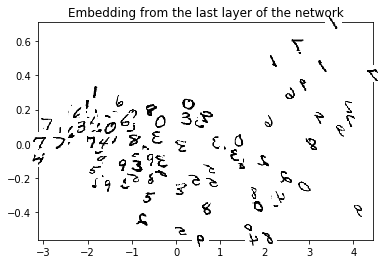

In [8]:
batch_size = 64
logging_frequency = 5
iterations = 100
to_embed = True
mnist_dataset = MnistDataset()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(iterations):
        batch = mnist_dataset.generate_train_data(batch_size)
        if i % logging_frequency == 0:
            loss = sess.run(triplet.loss, feed_dict={triplet.x: batch[0], triplet.xp: batch[1], triplet.xn: batch[2]}) 
            print('step %d, training loss %g' % (i, loss))
        train_step.run(feed_dict={triplet.x: batch[0], triplet.xp: batch[1], triplet.xn: batch[2]})
    test_batch = mnist_dataset.generate_test_data(100)[0]
    embed = triplet.o.eval({triplet.x: test_batch})
        
if to_embed:
    print(test_batch[0].size)
    visualize_embed.visualize(embed, test_batch[:,:,:,0])